#### Dedicato a Jack e Marco: ecco in azione l'*Istituto Centrale di Statistica*

In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import random as r
import matplotlib.pyplot as plt
import commonVar as cmv
import numpy as np

### stock-flow *model0*, the real part

- We are considering here uniquely the real part of the economy.

- No loans, credits, debts, capital stock, interest rate

- Enterpreneurs have unlimited funds that they put freely in their activities.

- Saving is abstension from consuming.

- Investments are uniquely ones, without technical progress


### symbol table

[symbol table](https://www.caam.rice.edu/~heinken/latex/symbols.pdf) in $\LaTeX$ 

$\mathcal{N}$ - number of agents, `agentNum`

$\mathcal{E}$ - employer number, a uniformly distributed integer number in range $[\mathcal{E}_{min},\mathcal{E}_{max}]$, `employerNum`

$p$ - price `price`

$u$ - unemployment rate `unemploymentRate`

$dimensional~heterogeneity$ is a $true/false$ chooser, forcing increasing firms to attract more workers. `dimensionalHeterogeneity`

$\pi_{i,t}$ - labor productivity, a uniformly distributed decimal number in range $[\pi_{min},\pi_{max}]$,`productivity`

&Delta;$\pi_{i,t}$ - uniperiodal additive productivity correction in range $[$&Delta;$\pi_{min},$ &Delta;$\pi_{max}]$, `productivityDelta`

$n_{i,t}$ - number of workers in a firm, set just in time

$q_{i,t}$ - production in quantity, `production`

$\Pi_{i,t}$ - profit, `profit`

$w$ - wage `wage`

$r_{i,t}$ - revenues, `revenues`

$s_{i,t}$ - sales, `sales`

$v_{i,t}$ - in**v**entories (final, initial), `initialInventories`, `finalInventories`

$d_{i}$ - deperibility share of the production, `deperibilityShare`, setting $d_{max}$

$c_{i,t}$ - consumption rate, a uniformly distributed decimal number in range $[c_{min},c_{max}]$,`consumptionRate`

$C_{i,t}$ - consumption of $i$ in $t$

numero atti acquisto DA FARE

$T$ - number of cycles `ncycles`

$t$ - cycle `cycle`


### model parameters

In [3]:
cmv.agentNum=100
employerMin=5
employerMax=20

cmv.price=1

cmv.unemploymentRate=0
cmv.dimensionalEtherogeneity=True

cmv.productivityMin=0.8
cmv.productivityMax=1.2
cmv.productivityDeltaMin=cmv.productivityMin-1
cmv.productivityDeltaMax=cmv.productivityMax-1

cmv.maxDeperibilityShare=0.5

cmv.wage=1
cmv.consumptionRateMin=0.5
cmv.consumptionRateMax=1

cmv.investmentMin=0
cmv.investmentMax=4

cmv.nOfConsumptionActions=30
cmv.nOfInvestmentActions=30
cmv.ncycles=100
cmv.cycle=0

### agent structure

The structure of a generic agent: it can represent and employer, a worker, an unemployed person.

When an agent is created, the **initialization process** defines:

- its numerical id, `num`

- its employer status, `employer`, set to $false$
- the id of its employer, `myEmployer`, set to $0$
- $r_{i,0}$ - `revenues`, initial value  $0$
- $s_{i,0}$ - `sales`, , initial value  $0$
- $v_{i,0}$ - inventories, `initialInventories`, set to $0$ 
- $d_{i}$ - deperibility share, a uniformly distributed decimal number in range $[0,d_{max}]$,`deperibilityShare`
- $w$ - `wage`, currently a fixed value



each agent has the functions:

- **produce** function, used only if is an employer, with:

  $\pi_{i,t}=\pi_{i,t-1}+\Delta\pi_{i,t}$

  $q_{i,t}=n_{i,t} \pi_{i,t}$
  

- **payWages**

  if employer, pays $w$ to each employee in each time $t$
  

- **buyConsumptionGoods** 

  $C_{i,t}=c_{i,t} (w+\Pi_{i,t-1})$



In [4]:
class Agent():
    def __init__(self, num):
        self.num=num
        self.employer=False
        self.myEmployer=0
        self.revenues=0 #sales*price
        self.sales=0
        self.initialInventories=0
        self.finalInventories=0
        self.deperibilityShare=r.uniform(0,cmv.maxDeperibilityShare)
        self.wallet=0
        self.consumptionRate=0
        self.investmentProgram=0
        self.profit=0

    def produce(self):
        self.initialInventories=self.finalInventories
        self.productivity+=r.uniform(cmv.productivityDeltaMin,cmv.productivityDeltaMax)
        self.productivity=max(self.productivity,0)
        
        self.production=len(self.myWorkers)*self.productivity
        self.sales=0
    
    def payWages(self):
        for anAgent in self.myWorkers:
            anAgent.wallet+=cmv.wage
            
    def buyConsumptionGoods(self,k):
        if k==0: 
            self.consumptionRate=r.uniform(cmv.consumptionRateMin,cmv.consumptionRateMax)
            self.consumption=(cmv.wage+self.profit)*self.consumptionRate
            if self.consumption < 0: self.consumption=0
            self.madeConsumption=0
                
        r.shuffle(cmv.employerList)
        mySeller=cmv.employerList[0]
        self.purchase=r.uniform(0,1/5)*self.consumption 
                            # mean value 0.10 (10 buy action could be sufficient)
        self.purchase=min(self.purchase,mySeller.production+mySeller.initialInventories\
                          -mySeller.sales)
        mySeller.sales+=self.purchase
        self.consumption-=self.purchase
        self.madeConsumption+=self.purchase
    
    def buyInvestmentGoods(self,k):
        if k==0: 
            self.investmentProgram=r.uniform(cmv.investmentMin,cmv.investmentMax)
            self.madeInvestment=0
                       
        r.shuffle(cmv.employerList)
        mySeller=cmv.employerList[0]
        self.myInvestment=min(self.investmentProgram,mySeller.production+mySeller.initialInventories\
                          -mySeller.sales)
        mySeller.sales+=self.myInvestment
        self.investmentProgram-=self.myInvestment
        self.madeInvestment+=self.myInvestment
        
        
    def makeBalanceSheet(self):
        self.lostProduction=0
        if self.production - self.sales > 0: 
            self.lostProduction=(self.production - self.sales)*self.deperibilityShare
        #print(self.num, lostProduction,self.productivity)
        self.finalInventories=self.initialInventories+self.production-\
                              self.sales-self.lostProduction
        self.revenues=self.sales*cmv.price
        self.profit=self.revenues - len(self.myWorkers)*cmv.wage + \
          (self.finalInventories-self.initialInventories)*cmv.price
        #print(self.num,self.profit,self.revenues,len(self.myWorkers)*cmv.wage,\
        #      self.finalInventories, self.initialInventories)
        self.wallet+=self.profit
        


### agent setup

In [5]:
def setup():
    cmv.employerNum=r.randint(employerMin, employerMax)
    cmv.agentList=[]
    for n in range(cmv.agentNum):
        anAgent=Agent(n+1)
        cmv.agentList.append(anAgent)
    

    # creation of employer list
    cmv.employerList=[]
    employerCandidates=cmv.agentList.copy()

    for n in range(cmv.employerNum):
        i=r.randint(0,len(employerCandidates))
        employerCandidates[i].employer=True
        employerCandidates[i].myEmployer=employerCandidates[i]
        employerCandidates[i].myWorkers=[employerCandidates[i]]
        employerCandidates[i].productivity=r.uniform(cmv.productivityMin,cmv.productivityMax)
        cmv.employerList.append(employerCandidates.pop(i))
    

    # creation of workforce list
    toBeEmployed=[]

    for anAgent in cmv.agentList:
        if not anAgent.employer: toBeEmployed.append(anAgent)
    for k in range(round(cmv.unemploymentRate*cmv.agentNum)):
        toBeEmployed.pop(r.randint(0,len(toBeEmployed)))
    #len(toBeEmployed)


    # assigning workforce to employers
    tmpEmployerListWithDuplications=[]
    for anAgent in cmv.agentList:
        if anAgent.employer: tmpEmployerListWithDuplications.append(anAgent)
    for anAgent in toBeEmployed:
        choice=r.choice(tmpEmployerListWithDuplications)
        anAgent.myEmployer=choice
        choice.myWorkers.append(anAgent)
        if cmv.dimensionalEtherogeneity: tmpEmployerListWithDuplications.append(choice)
            
    cmv.totalProductionSeries=[]
    cmv.totalProductionInfraVarSeries=[]
    cmv.totalProfitSeries=[]
    cmv.totalProfitInfraVarSeries=[]
    cmv.totalInitialInventoriesSeries=[]
    cmv.totalInitialInventoriesInfraVarSeries=[]
    cmv.totalFinalInventoriesSeries=[]
    cmv.totalFinalInventoriesInfraVarSeries=[]
    cmv.totalConsumptionSeries=[]
    cmv.totalConsumptionInfraVarSeries=[]
    cmv.totalInvestmentSeries=[]
    cmv.totalInvestmentInfraVarSeries=[]

    cmv.totalLostProductionSeries=[]


### ------------------------------------------------------------------

In [6]:
def produceAll():
    cmv.totalProductionSeries.append(0)
    cmv.totalProductionInfraVarSeries.append(0)
    cmv.totalInitialInventoriesSeries.append(0)
    cmv.totalInitialInventoriesInfraVarSeries.append(0)
    for anAgent in cmv.agentList:
        if anAgent.employer: 
            anAgent.produce()
            cmv.totalProductionSeries[-1]+=anAgent.production
            cmv.totalProductionInfraVarSeries[-1]+=anAgent.production**2
            cmv.totalInitialInventoriesSeries[-1]+=anAgent.initialInventories
            cmv.totalInitialInventoriesInfraVarSeries[-1]+=anAgent.initialInventories**2

    cmv.totalProductionInfraVarSeries[-1]=\
                            (cmv.totalProductionInfraVarSeries[-1]/cmv.employerNum - \
                            (cmv.totalProductionSeries[-1]/cmv.employerNum)**2)
    cmv.totalInitialInventoriesInfraVarSeries[-1]=\
                            (cmv.totalInitialInventoriesInfraVarSeries[-1]/cmv.employerNum - \
                            (cmv.totalInitialInventoriesSeries[-1]/cmv.employerNum)**2)
                                          

In [7]:
def payWagesAll():
    for anAgent in cmv.agentList:
        if anAgent.employer:
            anAgent.payWages()


In [8]:
def buyConsumptionGoodsAll():
    cmv.totalConsumptionSeries.append(0)
    cmv.totalConsumptionInfraVarSeries.append(0)
    for k in range(cmv.nOfConsumptionActions):
        r.shuffle(cmv.agentList)
        for anAgent in cmv.agentList:
            anAgent.buyConsumptionGoods(k)
            if k==cmv.nOfConsumptionActions-1:
                cmv.totalConsumptionSeries[-1]+=anAgent.madeConsumption
                cmv.totalConsumptionInfraVarSeries[-1]+=anAgent.madeConsumption**2
    cmv.totalConsumptionInfraVarSeries[-1]=\
                              (cmv.totalConsumptionInfraVarSeries[-1]/cmv.agentNum - \
                              (cmv.totalConsumptionSeries[-1]/cmv.agentNum)**2)
                

In [9]:
def buyInvestmentGoodsAll():
    cmv.totalInvestmentSeries.append(0)
    cmv.totalInvestmentInfraVarSeries.append(0)
    for k in range(cmv.nOfInvestmentActions):
        for anAgent in cmv.agentList:
            if anAgent.employer:
                anAgent.buyInvestmentGoods(k)
                if k==cmv.nOfInvestmentActions-1:
                    cmv.totalInvestmentSeries[-1]+=anAgent.madeInvestment
                    cmv.totalInvestmentInfraVarSeries[-1]+=anAgent.madeInvestment**2
    cmv.totalInvestmentInfraVarSeries[-1]=\
                              (cmv.totalInvestmentInfraVarSeries[-1]/cmv.employerNum - \
                              (cmv.totalInvestmentSeries[-1]/cmv.employerNum)**2)
                

In [10]:
def makeBalanceSheetAll():
    cmv.totalProfitSeries.append(0)
    cmv.totalProfitInfraVarSeries.append(0)
    cmv.totalFinalInventoriesSeries.append(0)
    cmv.totalFinalInventoriesInfraVarSeries.append(0)
    cmv.totalLostProductionSeries.append(0)
    for anAgent in cmv.agentList:
        if anAgent.employer:
            anAgent.makeBalanceSheet()
            cmv.totalProfitSeries[-1]+=anAgent.profit
            cmv.totalProfitInfraVarSeries[-1]+=anAgent.profit**2
            cmv.totalFinalInventoriesSeries[-1]+=anAgent.finalInventories
            cmv.totalFinalInventoriesInfraVarSeries[-1]+=anAgent.finalInventories**2
            cmv.totalLostProductionSeries[-1]+=anAgent.lostProduction

    cmv.totalProfitInfraVarSeries[-1]=(cmv.totalProfitInfraVarSeries[-1]/cmv.employerNum - \
                                          (cmv.totalProfitSeries[-1]/cmv.employerNum)**2)
    cmv.totalFinalInventoriesInfraVarSeries[-1]=\
                            (cmv.totalFinalInventoriesInfraVarSeries[-1]/cmv.employerNum - \
                            (cmv.totalFinalInventoriesSeries[-1]/cmv.employerNum)**2)
                                            

In [11]:
def makeHist():
    print("-------------------------------------------\n"+\
          "employer number "+ str(len(cmv.employerList))+\
          "\n-------------------------------------------\n")
    cmv.employerSizeList=[]
    list(cmv.employerSizeList.append(cmv.employerList[i].num) \
                                for i in range(len(cmv.employerList)))
    #print(cmv.employerSizeList)

    plt.hist(cmv.employerSizeList,20,facecolor='orange')
    plt.xlabel("# of employees")
    plt.ylabel("# of employeers")
    plt.title("Distribution of the employers by number of employees")      


def plot1():
    # https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/two_scales.html
    # https://matplotlib.org/3.5.1/tutorials/colors/colors.html
    myColor1 = 'tab:orange'
    myColor2 = 'tab:blue'
    fig1, ax1a = plt.subplots()
    ax1a.set_ylim([0, max(cmv.totalProductionSeries)])
    t=range(1,cmv.ncycles+1)
    ax1a.plot(t, cmv.totalProductionSeries, label="production", color=myColor1)
    ax1a.tick_params(axis='y', labelcolor=myColor1)
    
    ax2a = ax1a.twinx()  # instantiate a second axes that shares the same x-axis
    ax2a.set_ylim([0, max(cmv.totalProductionInfraVarSeries)])
    ax2a.plot(t, cmv.totalProductionInfraVarSeries, label="prodInVar", color=myColor2)
    ax2a.tick_params(axis='y', labelcolor=myColor2)
    fig1.legend()

def plot2():
    # https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/two_scales.html
    # https://matplotlib.org/3.5.1/tutorials/colors/colors.html
    myColor1 = 'tab:orange'
    myColor2 = 'tab:blue'
    fig2, ax1b = plt.subplots()
    ax1b.set_ylim([min(cmv.totalProfitSeries), max(0,max(cmv.totalProfitSeries))])
    t=range(1,cmv.ncycles+1)
    ax1b.plot(t, cmv.totalProfitSeries, label="profit", color=myColor1)
    ax1b.tick_params(axis='y', labelcolor=myColor1)
    ax1b.plot([1,cmv.ncycles],[0,0], label="zero line", color=myColor1, linestyle='dashed')

    ax2b = ax1b.twinx()  # instantiate a second axes that shares the same x-axis
    ax2b.set_ylim([0, max(cmv.totalProfitInfraVarSeries)])
    ax2b.plot(t, cmv.totalProfitInfraVarSeries, label="profInVar", color=myColor2)
    ax2b.tick_params(axis='y', labelcolor=myColor2)
    fig2.legend()

def plot3():
    # https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/two_scales.html
    # https://matplotlib.org/3.5.1/tutorials/colors/colors.html
    myColor1 = 'tab:orange'
    myColor2 = 'tab:blue'
    fig3, ax1c = plt.subplots()
    ax1c.set_ylim([min(cmv.totalInitialInventoriesSeries), \
                   max(0,max(cmv.totalInitialInventoriesSeries))])
    t=range(1,cmv.ncycles+1)
    ax1c.plot(t, cmv.totalInitialInventoriesSeries, label="initialInventories", \
              color=myColor1)
    ax1c.tick_params(axis='y', labelcolor=myColor1)
    ax1c.plot([1,cmv.ncycles],[0,0], label="zero line", color=myColor1, linestyle='dashed')

    ax2c = ax1c.twinx()  # instantiate a second axes that shares the same x-axis
    ax2c.set_ylim([0, max(cmv.totalInitialInventoriesInfraVarSeries)])
    ax2c.plot(t, cmv.totalInitialInventoriesInfraVarSeries, label="initialInventoriesInVar",\
              color=myColor2)
    ax2c.tick_params(axis='y', labelcolor=myColor2)
    fig3.legend()

def plot4():
    # https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/two_scales.html
    # https://matplotlib.org/3.5.1/tutorials/colors/colors.html
    myColor1 = 'tab:orange'
    myColor2 = 'tab:blue'
    fig4, ax1d = plt.subplots()
    ax1d.set_ylim([min(cmv.totalFinalInventoriesSeries), \
                   max(0,max(cmv.totalFinalInventoriesSeries))])
    t=range(1,cmv.ncycles+1)
    ax1d.plot(t, cmv.totalFinalInventoriesSeries, label="finalInventories", \
              color=myColor1)
    ax1d.tick_params(axis='y', labelcolor=myColor1)
    ax1d.plot([1,cmv.ncycles],[0,0], label="zero line", color=myColor1, linestyle='dashed')

    ax2d = ax1d.twinx()  # instantiate a second axes that shares the same x-axis
    ax2d.set_ylim([0, max(cmv.totalFinalInventoriesInfraVarSeries)])
    ax2d.plot(t, cmv.totalFinalInventoriesInfraVarSeries, label="finalInventoriesInVar",\
              color=myColor2)
    ax2d.tick_params(axis='y', labelcolor=myColor2)
    fig4.legend()

def plot5():
    # https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/two_scales.html
    # https://matplotlib.org/3.5.1/tutorials/colors/colors.html
    myColor1 = 'tab:orange'
    myColor2 = 'tab:blue'
    fig5, ax1e = plt.subplots()
    ax1e.set_ylim([0, max(cmv.totalConsumptionSeries)])
    t=range(1,cmv.ncycles+1)
    ax1e.plot(t, cmv.totalConsumptionSeries, label="consumption", color=myColor1)
    ax1e.tick_params(axis='y', labelcolor=myColor1)
    
    ax2e = ax1e.twinx()  # instantiate a second axes that shares the same x-axis
    ax2e.set_ylim([0, max(cmv.totalConsumptionInfraVarSeries)])
    ax2e.plot(t, cmv.totalConsumptionInfraVarSeries, label="consInVar", color=myColor2)
    ax2e.tick_params(axis='y', labelcolor=myColor2)
    fig5.legend()

def plot6():
    # https://matplotlib.org/3.5.1/gallery/subplots_axes_and_figures/two_scales.html
    # https://matplotlib.org/3.5.1/tutorials/colors/colors.html
    myColor1 = 'tab:orange'
    myColor2 = 'tab:blue'
    fig6, ax1f = plt.subplots()
    ax1f.set_ylim([0, max(cmv.totalInvestmentSeries)])
    t=range(1,cmv.ncycles+1)
    ax1f.plot(t, cmv.totalInvestmentSeries, label="investment", color=myColor1)
    ax1f.tick_params(axis='y', labelcolor=myColor1)
    
    ax2f = ax1f.twinx()  # instantiate a second axes that shares the same x-axis
    ax2f.set_ylim([0, max(cmv.totalInvestmentInfraVarSeries)])
    ax2f.plot(t, cmv.totalInvestmentInfraVarSeries, label="investInVar", color=myColor2)
    ax2f.tick_params(axis='y', labelcolor=myColor2)
    fig6.legend()



In [12]:
def nationalAccounts():
    print("-------------------------------------------\n"+\
          '"national" accounts'+\
          "\n-------------------------------------------\n")
    print("%s\t%s\t%s\t%s\t\t%s\t%s\t%s" % \
          ("t","total","lost","initial","consum.","invest.","final"))
    print("\t%s\t%s\t%s\t\t\t\t%s" % ("produc.","produc.","invent.","invent."))
    for i in range(cmv.ncycles):
        print("%3d\t%.1f\t%.1f\t%.1f\t    |\t%.1f\t%.1f\t%.1f" % \
                                   (i+1,cmv.totalProductionSeries[i],
                                   -cmv.totalLostProductionSeries[i],\
                                   cmv.totalInitialInventoriesSeries[i],\
                                   cmv.totalConsumptionSeries[i],\
                                   cmv.totalInvestmentSeries[i],\
                                   cmv.totalFinalInventoriesSeries[i]))
        
    print("\n\n\n")

### model machine

-------------------------------------------
employer number 19
-------------------------------------------

-------------------------------------------
"national" accounts
-------------------------------------------

t	total	lost	initial		consum.	invest.	final
	produc.	produc.	invent.				invent.
  1	102.3	0.0	0.0	    |	64.6	37.7	0.0
  2	101.0	-0.8	0.0	    |	65.4	32.6	2.1
  3	102.8	-0.3	2.1	    |	68.1	29.7	6.8
  4	100.5	0.0	6.8	    |	68.1	35.6	3.6
  5	102.7	0.0	3.6	    |	65.5	40.8	0.0
  6	110.0	-1.7	0.0	    |	69.2	30.4	8.8
  7	105.6	-1.7	8.8	    |	72.8	30.3	9.6
  8	103.8	-1.2	9.6	    |	70.6	39.9	1.8
  9	103.5	-0.1	1.8	    |	67.6	35.5	2.1
 10	102.8	-0.0	2.1	    |	70.1	31.7	3.1
 11	98.8	-0.0	3.1	    |	70.9	27.3	3.7
 12	92.2	0.0	3.7	    |	67.0	28.8	0.0
 13	91.6	0.0	0.0	    |	67.4	24.2	0.0
 14	90.0	0.0	0.0	    |	64.9	25.1	0.0
 15	87.0	0.0	0.0	    |	65.3	21.7	0.0
 16	87.3	0.0	0.0	    |	64.0	23.4	0.0
 17	90.2	0.0	0.0	    |	65.4	24.9	0.0
 18	88.5	-0.1	0.0	    |	63.0	22.5	2.8
 19	93.3	0.0	2.8	 

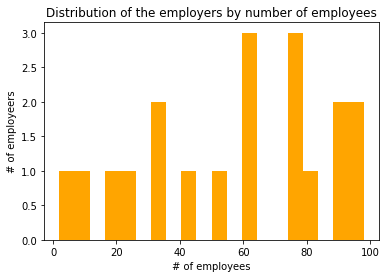

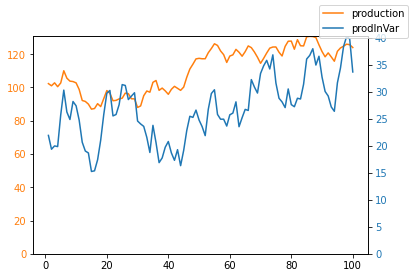

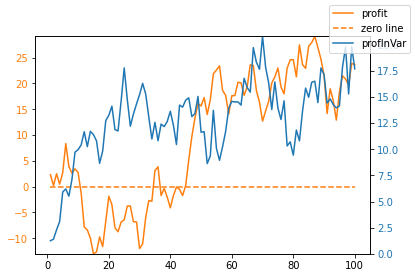

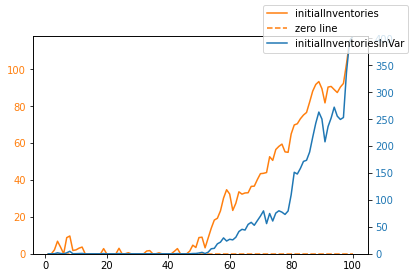

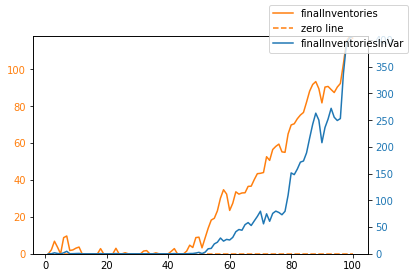

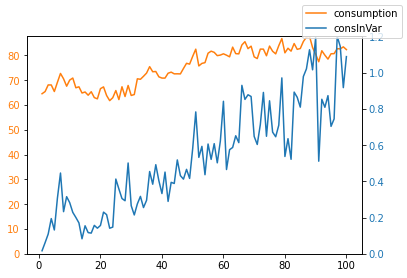

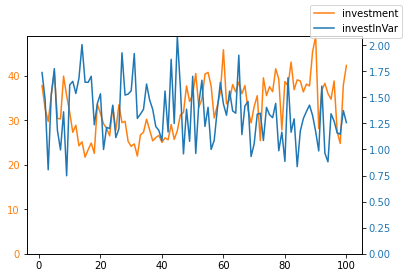

In [13]:
r.seed(121314)

setup()

cmv.actionList=["produceAll()","payWagesAll()","buyConsumptionGoodsAll()",\
                "buyInvestmentGoodsAll()","makeBalanceSheetAll()"]

for cmv.cycle in range(cmv.ncycles):
    for anAction in cmv.actionList:
            exec(anAction)

makeHist()   
plot1()
plot2()
plot3()
plot4()
plot5()
plot6()

nationalAccounts()